# Goodreads books data analysis

This notebook performs some exploratory analysis on the [Goodreads books dataset](https://www.kaggle.com/jealousleopard/goodreadsbooks) found on Kaggle.

This dataset is small enough that we could use Pandas, but for learning purposes I'll be using Spark.

## Setup and load data

In [1]:
import os

import findspark
findspark.init()

from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, FloatType, StringType, StructField, StructType
from pyspark_dist_explore import hist

%matplotlib inline

spark = SparkSession.builder.appName("ExploreGoodreads").getOrCreate()

In [2]:
load_dotenv()

GOODREADS_BOOKS_PATH = os.getenv("GOODREADS_BOOKS_PATH")

In [3]:
book_schema = StructType([
    StructField("bookID", StringType(), True),
    StructField("title", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("isbn", StringType(), True),
    StructField("isbn13", StringType(), True),
    StructField("language_code", StringType(), True),
    StructField("num_pages", IntegerType(), True),    
    StructField("ratings_count", IntegerType(), True),    
    StructField("text_reviews_count", IntegerType(), True),
    StructField("publication_date", StringType(), True),
    StructField("publicater", StringType(), True),            
])
goodreads_df = spark.read.schema(book_schema).option("header", "true").csv(GOODREADS_BOOKS_PATH)

# Add a column that stores publication date as a datetime object
goodreads_df = goodreads_df.withColumn(
    "publication_date_ts", 
    F.to_timestamp(goodreads_df.publication_date, "MM/dd/yyyy"),
)

## Helpers

This section contains some helper functions that will be reused when analyzing each column.

In [4]:
def get_basic_counts(df, col):
    df.agg(
        F.count(col),
        F.countDistinct(col),
    ).show()
    
    
def check_nulls(df, col):
    df.where(col.isNull()).agg(
        F.count(col),
        F.countDistinct(col),
    ).show()

    
def check_empty_strings(df, col):
    df.where(col == "").agg(
        F.count(col),
        F.countDistinct(col),
    ).show()
   

def check_lengths(df, col):
    (
        df
        .select(col, F.length(col))
        .sort(F.length(col).asc())
        .show(5) 
    )
    (
        df
        .select(col, F.length(col))
        .sort(F.length(col).desc())
        .show(5) 
    )
    
    
def basic_stats(df, col):
    df.agg(
        F.count(col),
        F.avg(col),        
        F.min(col),
        F.max(col),
    ).show() 
    
    
def plot_hist(df, bins, title=None):
    fig, ax = plt.subplots()
    hist(ax, df, bins=bins, color=["blue"])
    if title:
        ax.set_title(title)
        _ = ax.legend()    

## Inspect table

In [5]:
goodreads_df.show(5)

+------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+-------------------+
|bookID|               title|             authors|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|     publicater|publication_date_ts|
+------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+-------------------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|2006-09-16 00:00:00|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|0439358078|9780439358071|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|2004-09-01 00:00

## BookID

In [6]:
get_basic_counts(goodreads_df, goodreads_df.bookID)
check_nulls(goodreads_df, goodreads_df.bookID)
check_lengths(goodreads_df, goodreads_df.bookID)

+-------------+----------------------+
|count(bookID)|count(DISTINCT bookID)|
+-------------+----------------------+
|        11127|                 11127|
+-------------+----------------------+

+-------------+----------------------+
|count(bookID)|count(DISTINCT bookID)|
+-------------+----------------------+
|            0|                     0|
+-------------+----------------------+

+------+--------------+
|bookID|length(bookID)|
+------+--------------+
|     1|             1|
|     2|             1|
|     4|             1|
|     5|             1|
|     8|             1|
+------+--------------+
only showing top 5 rows

+------+--------------+
|bookID|length(bookID)|
+------+--------------+
| 10000|             5|
| 10009|             5|
| 10002|             5|
| 10004|             5|
| 10006|             5|
+------+--------------+
only showing top 5 rows



## Title

In [7]:
get_basic_counts(goodreads_df, goodreads_df.title)
check_nulls(goodreads_df, goodreads_df.title)
check_empty_strings(goodreads_df, goodreads_df.title)
check_lengths(goodreads_df, goodreads_df.title)

+------------+---------------------+
|count(title)|count(DISTINCT title)|
+------------+---------------------+
|       11127|                10352|
+------------+---------------------+

+------------+---------------------+
|count(title)|count(DISTINCT title)|
+------------+---------------------+
|           0|                    0|
+------------+---------------------+

+------------+---------------------+
|count(title)|count(DISTINCT title)|
+------------+---------------------+
|           0|                    0|
+------------+---------------------+

+-----+-------------+
|title|length(title)|
+-----+-------------+
|   V.|            2|
|   V.|            2|
|   V.|            2|
|  Kim|            3|
|  Dry|            3|
+-----+-------------+
only showing top 5 rows

+--------------------+-------------+
|               title|length(title)|
+--------------------+-------------+
|Yours in Food  Jo...|          254|
|The covert war ag...|          210|
|Dr. Mary's Monkey...|          20

## Authors

In [8]:
get_basic_counts(goodreads_df, goodreads_df.authors)
check_nulls(goodreads_df, goodreads_df.authors)
check_empty_strings(goodreads_df, goodreads_df.authors)
check_lengths(goodreads_df, goodreads_df.authors)

+--------------+-----------------------+
|count(authors)|count(DISTINCT authors)|
+--------------+-----------------------+
|         11127|                   6643|
+--------------+-----------------------+

+--------------+-----------------------+
|count(authors)|count(DISTINCT authors)|
+--------------+-----------------------+
|             0|                      0|
+--------------+-----------------------+

+--------------+-----------------------+
|count(authors)|count(DISTINCT authors)|
+--------------+-----------------------+
|             0|                      0|
+--------------+-----------------------+

+-------+---------------+
|authors|length(authors)|
+-------+---------------+
|    Avi|              3|
|    Avi|              3|
|    Avi|              3|
|  Zolar|              5|
|  CLAMP|              5|
+-------+---------------+
only showing top 5 rows

+--------------------+---------------+
|             authors|length(authors)|
+--------------------+---------------+
|Garri

In [9]:
(
    goodreads_df
    .groupBy(goodreads_df.authors)
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.average_rating).alias("avg_average_rating"),
        F.min(goodreads_df.average_rating).alias("min_average_rating"),
        F.max(goodreads_df.average_rating).alias("max_average_rating"),
     )
     .sort(F.desc("total_title"))
     .show(5)
)
(
    goodreads_df
    .groupBy(goodreads_df.authors)
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.ratings_count).alias("avg_ratings_count"),        
        F.min(goodreads_df.ratings_count).alias("min_ratings_rating"),
        F.max(goodreads_df.ratings_count).alias("max_ratings_count"),    
     )
     .sort(F.desc("total_title"))
     .show(5)
)
(
    goodreads_df
    .groupBy(goodreads_df.authors)
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.text_reviews_count).alias("avg_reviews_count"),               
        F.min(goodreads_df.text_reviews_count).alias("min_reviews_count"),        
        F.max(goodreads_df.text_reviews_count).alias("max_reviews_count"),         
     )
     .sort(F.desc("total_title"))
     .show(5)
)

+----------------+-----------+------------------+------------------+------------------+
|         authors|total_title|avg_average_rating|min_average_rating|max_average_rating|
+----------------+-----------+------------------+------------------+------------------+
|  P.G. Wodehouse|         40| 4.147250026464462|              3.78|              4.48|
|    Stephen King|         40| 3.973499995470047|              3.32|              4.54|
|Rumiko Takahashi|         39|4.1866667209527435|              3.88|              4.36|
|Orson Scott Card|         35|3.7791428702218193|              3.33|              4.49|
| Agatha Christie|         33|3.9890909267194345|              3.66|              4.39|
+----------------+-----------+------------------+------------------+------------------+
only showing top 5 rows

+----------------+-----------+------------------+------------------+-----------------+
|         authors|total_title| avg_ratings_count|min_ratings_rating|max_ratings_count|
+--------

## Average Rating

+---------------------+------------------------------+
|count(average_rating)|count(DISTINCT average_rating)|
+---------------------+------------------------------+
|                11123|                           209|
+---------------------+------------------------------+

+---------------------+------------------------------+
|count(average_rating)|count(DISTINCT average_rating)|
+---------------------+------------------------------+
|                    0|                             0|
+---------------------+------------------------------+

+---------------------+-------------------+-------------------+-------------------+
|count(average_rating)|avg(average_rating)|min(average_rating)|max(average_rating)|
+---------------------+-------------------+-------------------+-------------------+
|                11123| 3.9340753506533823|                0.0|                5.0|
+---------------------+-------------------+-------------------+-------------------+



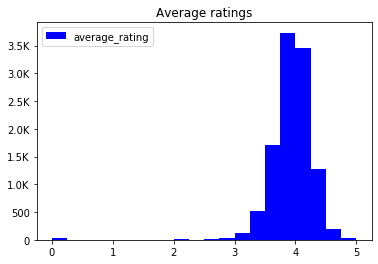

In [10]:
get_basic_counts(goodreads_df, goodreads_df.average_rating)
check_nulls(goodreads_df, goodreads_df.average_rating)
basic_stats(goodreads_df, goodreads_df.average_rating)
plot_hist(goodreads_df.select(goodreads_df.average_rating), bins=20, title="Average ratings")

## Number of pages

+----------------+-------------------------+
|count(num_pages)|count(DISTINCT num_pages)|
+----------------+-------------------------+
|           11123|                      997|
+----------------+-------------------------+

+----------------+-------------------------+
|count(num_pages)|count(DISTINCT num_pages)|
+----------------+-------------------------+
|               0|                        0|
+----------------+-------------------------+

+----------------+-----------------+--------------+--------------+
|count(num_pages)|   avg(num_pages)|min(num_pages)|max(num_pages)|
+----------------+-----------------+--------------+--------------+
|           11123|336.4055560550211|             0|          6576|
+----------------+-----------------+--------------+--------------+



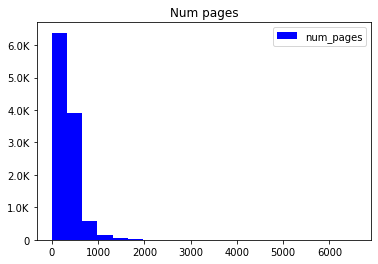

In [11]:
get_basic_counts(goodreads_df, goodreads_df.num_pages)
check_nulls(goodreads_df, goodreads_df.num_pages)
basic_stats(goodreads_df, goodreads_df.num_pages)
plot_hist(goodreads_df.select(goodreads_df.num_pages), bins=20, title="Num pages")

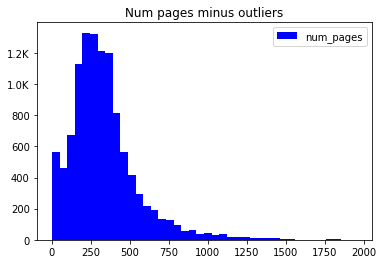

In [12]:
num_pages_df_no_outlier = goodreads_df.select(goodreads_df.num_pages).filter(goodreads_df.num_pages < 2000)
plot_hist(num_pages_df_no_outlier, bins=40, title="Num pages minus outliers")

## ISBN

In [13]:
get_basic_counts(goodreads_df, goodreads_df.isbn)
check_nulls(goodreads_df, goodreads_df.isbn)
check_empty_strings(goodreads_df, goodreads_df.isbn)

+-----------+--------------------+
|count(isbn)|count(DISTINCT isbn)|
+-----------+--------------------+
|      11127|               11126|
+-----------+--------------------+

+-----------+--------------------+
|count(isbn)|count(DISTINCT isbn)|
+-----------+--------------------+
|          0|                   0|
+-----------+--------------------+

+-----------+--------------------+
|count(isbn)|count(DISTINCT isbn)|
+-----------+--------------------+
|          0|                   0|
+-----------+--------------------+



### Check ISBN lengths

Looks like there are some ISBNS with invalid values.

In [14]:
check_lengths(goodreads_df, goodreads_df.isbn)

+---------+------------+
|     isbn|length(isbn)|
+---------+------------+
|     3.58|           4|
|     0.00|           4|
|     3.58|           4|
|     3.63|           4|
|084386874|           9|
+---------+------------+
only showing top 5 rows

+----------+------------+
|      isbn|length(isbn)|
+----------+------------+
|0439785960|          10|
|0439358078|          10|
|0439554896|          10|
|043965548X|          10|
|0439682584|          10|
+----------+------------+
only showing top 5 rows



## ISBN13

In [15]:
get_basic_counts(goodreads_df, goodreads_df.isbn13)
check_nulls(goodreads_df, goodreads_df.isbn13)
check_empty_strings(goodreads_df, goodreads_df.isbn13)

+-------------+----------------------+
|count(isbn13)|count(DISTINCT isbn13)|
+-------------+----------------------+
|        11127|                 11127|
+-------------+----------------------+

+-------------+----------------------+
|count(isbn13)|count(DISTINCT isbn13)|
+-------------+----------------------+
|            0|                     0|
+-------------+----------------------+

+-------------+----------------------+
|count(isbn13)|count(DISTINCT isbn13)|
+-------------+----------------------+
|            0|                     0|
+-------------+----------------------+



## Check ISBN13 lengths

Looks like there are a few ISBNs instead ISBN13s

In [16]:
check_lengths(goodreads_df, goodreads_df.isbn13)

+-------------+--------------+
|       isbn13|length(isbn13)|
+-------------+--------------+
|   0674842111|            10|
|   0851742718|            10|
|   1593600119|            10|
|   156384155X|            10|
|9780439785969|            13|
+-------------+--------------+
only showing top 5 rows

+-------------+--------------+
|       isbn13|length(isbn13)|
+-------------+--------------+
|9780439785969|            13|
|9780439358071|            13|
|9780439554893|            13|
|9780439655484|            13|
|9780439682589|            13|
+-------------+--------------+
only showing top 5 rows



## Language code

In [17]:
get_basic_counts(goodreads_df, goodreads_df.language_code)
check_nulls(goodreads_df, goodreads_df.language_code)
check_empty_strings(goodreads_df, goodreads_df.language_code)

+--------------------+-----------------------------+
|count(language_code)|count(DISTINCT language_code)|
+--------------------+-----------------------------+
|               11127|                           31|
+--------------------+-----------------------------+

+--------------------+-----------------------------+
|count(language_code)|count(DISTINCT language_code)|
+--------------------+-----------------------------+
|                   0|                            0|
+--------------------+-----------------------------+

+--------------------+-----------------------------+
|count(language_code)|count(DISTINCT language_code)|
+--------------------+-----------------------------+
|                   0|                            0|
+--------------------+-----------------------------+



### Check unique language codes

Looks like some language codes are ISBNs.

In [18]:
(
    goodreads_df
    .select(goodreads_df.language_code)
    .distinct()
    .sort(goodreads_df.language_code.desc()).show(31)
)

+-------------+
|language_code|
+-------------+
|          zho|
|          wel|
|          tur|
|          swe|
|          srp|
|          spa|
|          rus|
|          por|
|          nor|
|           nl|
|          mul|
|          msa|
|          lat|
|          jpn|
|          ita|
|          grc|
|          glg|
|          gla|
|          ger|
|          fre|
|          enm|
|          eng|
|        en-US|
|        en-GB|
|        en-CA|
|          ara|
|          ale|
|9781593600112|
|9781563841552|
|9780851742717|
|9780674842113|
+-------------+



## Ratings count

+--------------------+-----------------------------+
|count(ratings_count)|count(DISTINCT ratings_count)|
+--------------------+-----------------------------+
|               11127|                         5294|
+--------------------+-----------------------------+

+--------------------+-----------------------------+
|count(ratings_count)|count(DISTINCT ratings_count)|
+--------------------+-----------------------------+
|                   0|                            0|
+--------------------+-----------------------------+

+--------------------+------------------+------------------+------------------+
|count(ratings_count)|avg(ratings_count)|min(ratings_count)|max(ratings_count)|
+--------------------+------------------+------------------+------------------+
|               11127|17936.490159072528|                 0|           4597666|
+--------------------+------------------+------------------+------------------+



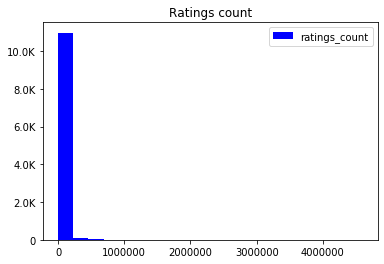

In [19]:
get_basic_counts(goodreads_df, goodreads_df.ratings_count)
check_nulls(goodreads_df, goodreads_df.ratings_count)
basic_stats(goodreads_df, goodreads_df.ratings_count)
plot_hist(goodreads_df.select(goodreads_df.ratings_count), bins=20, title="Ratings count")

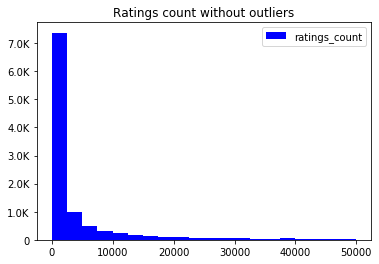

In [20]:
plot_hist(
    goodreads_df.select(goodreads_df.ratings_count).filter(goodreads_df.ratings_count < 50000), 
    bins=20, 
    title="Ratings count without outliers",
)


## Text reviews count

+-------------------------+----------------------------------+
|count(text_reviews_count)|count(DISTINCT text_reviews_count)|
+-------------------------+----------------------------------+
|                    11127|                              1822|
+-------------------------+----------------------------------+

+-------------------------+----------------------------------+
|count(text_reviews_count)|count(DISTINCT text_reviews_count)|
+-------------------------+----------------------------------+
|                        0|                                 0|
+-------------------------+----------------------------------+

+-------------------------+-----------------------+-----------------------+-----------------------+
|count(text_reviews_count)|avg(text_reviews_count)|min(text_reviews_count)|max(text_reviews_count)|
+-------------------------+-----------------------+-----------------------+-----------------------+
|                    11127|      541.8644738024625|                 

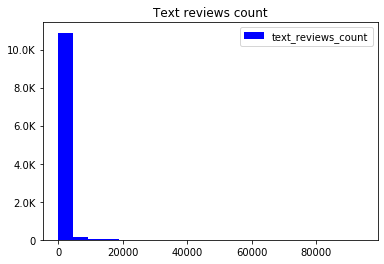

In [21]:
get_basic_counts(goodreads_df, goodreads_df.text_reviews_count)
check_nulls(goodreads_df, goodreads_df.text_reviews_count)
basic_stats(goodreads_df, goodreads_df.text_reviews_count)
plot_hist(goodreads_df.select(goodreads_df.text_reviews_count), bins=20, title="Text reviews count")

## Publication date

The 1900-01-01 date sounds suspicious since in Python27 the date class had bug with dates earlier than 1900. Is it the case in Python38 as well?

In [23]:
get_basic_counts(goodreads_df, goodreads_df.publication_date_ts)
check_nulls(goodreads_df, goodreads_df.publication_date_ts)
basic_stats(goodreads_df, goodreads_df.publication_date_ts)

+--------------------------+-----------------------------------+
|count(publication_date_ts)|count(DISTINCT publication_date_ts)|
+--------------------------+-----------------------------------+
|                     11121|                               3677|
+--------------------------+-----------------------------------+

+--------------------------+-----------------------------------+
|count(publication_date_ts)|count(DISTINCT publication_date_ts)|
+--------------------------+-----------------------------------+
|                         0|                                  0|
+--------------------------+-----------------------------------+

+--------------------------+------------------------+------------------------+------------------------+
|count(publication_date_ts)|avg(publication_date_ts)|min(publication_date_ts)|max(publication_date_ts)|
+--------------------------+------------------------+------------------------+------------------------+
|                     11121|     9.6

## Publicator

In [25]:
get_basic_counts(goodreads_df, goodreads_df.publicater)
check_nulls(goodreads_df, goodreads_df.publicater)
check_lengths(goodreads_df, goodreads_df.publicater)

+-----------------+--------------------------+
|count(publicater)|count(DISTINCT publicater)|
+-----------------+--------------------------+
|            11127|                      2294|
+-----------------+--------------------------+

+-----------------+--------------------------+
|count(publicater)|count(DISTINCT publicater)|
+-----------------+--------------------------+
|                0|                         0|
+-----------------+--------------------------+

+----------+------------------+
|publicater|length(publicater)|
+----------+------------------+
|        DK|                 2|
|      東立|                 2|
|        DK|                 2|
|      東立|                 2|
|      東立|                 2|
+----------+------------------+
only showing top 5 rows

+--------------------+------------------+
|          publicater|length(publicater)|
+--------------------+------------------+
|Harvard Universit...|                67|
|Crown Journeys/Cr...|                67|
|Prentice H

In [32]:
(
    goodreads_df
    .select(goodreads_df.publicater)
    .distinct()
    .filter(F.lower(goodreads_df.publicater).startswith("s"))
    .sort(goodreads_df.publicater.asc()).show()
)

+--------------------+
|          publicater|
+--------------------+
|           SCM Press|
|Saddleback Educat...|
|Sage Publications...|
|Sage Publications...|
|           Sagebrush|
|          Salamandra|
|              Salani|
|     Salem Press Inc|
|           SaltRiver|
|  Samhain Publishing|
|                Sams|
| Samuel French  Inc.|
|   Samuel French Ltd|
|             San Val|
|Santillana USA Pu...|
|Sarah Crichton Books|
|     Sasquatch Books|
|            Saunders|
|             Sceptre|
|      Schirmer Mosel|
+--------------------+
only showing top 20 rows

